Simulates what a modeler would do when following the proposed pipeline

In [1]:
import numpy as np
import os
import json
from IPython.display import display, clear_output
import ipywidgets as ipw

import sim_lib

res_dir = os.path.join('results', 'workflow_sim_1')

In [2]:
model_string_antimony = """
species S, I, R, V;

S -> I ; beta * S * V;
I -> R ; delta * I;
-> V  ; p * I - k * V;

S = 1E6;
I = 0.0;
R = 0.0;
V = 2.0;

beta = 2.0E-6;
k = 4.0;
delta = 1E0;
p = 25.0;
"""
var_names = ['S', 'I', 'R', 'V']
err_thresh = 0.075
stochastic = False
t_fin = 10.0
num_steps = 101
num_samples_incr = 100
param_dist = {'beta': ('norm', (2.0E-6, 0.2E-6))}

model_string_sbml = sim_lib.antimony_to_sbml(model_string_antimony)

Definitions for collecting results

In [3]:
def extend_arrs(_arr: np.ndarray, _num_extend: int):
    if _num_extend <= 0:
        raise ValueError

    result = np.zeros((_arr.shape[0] + _num_extend, _arr.shape[1]), dtype=float)
    result[:_arr.shape[0], :] = _arr
    return result


def extract_rr_time(_res):
    return _res[:, _res.colnames.index('time')]


def extract_rr_results(_res, _var_name: str):
    return _res[:, _res.colnames.index(f'[{_var_name}]')]


sim_lib.start_pool()

The simulation

In [4]:
out = ipw.Output()
display(out)
subout = ipw.Output()
display(subout)

Output()

Output()

In [5]:
# Runtime: ~13 minutes (M1 max, can vary a lot)

sampling_err_thresh = 0.001
sample_times = np.array([t_fin / num_steps * i for i in range(0, num_steps + 1)], dtype=float)

num_times = len(sample_times)
results = {name: np.zeros((num_samples_incr, num_steps), dtype=float) for name in var_names}

stat_hist = []
err_hist = []
iter_current = 0
err_current = min(1, err_thresh + 1)
ecf_eval_info = []
ks_stats_samp = []
idx_current = 0
rr = sim_lib.make_rr(model_string_sbml, stochastic)

results_times = extract_rr_time(sim_lib.exec_rr(rr, t_fin, num_steps, stochastic))
rr.resetAll()

while err_current >= err_thresh:

    with out:
        clear_output()

    if iter_current > 0:
        out.append_stdout(f'Iteration {iter_current} ({idx_current}): {stat_hist[-1][1]}, {stat_hist[-1][2]} ({err_thresh})\n')
    else:
        out.append_stdout(f'Iteration {iter_current} ({idx_current}): ({err_thresh})\n')

    num_samples_incr_curr = num_samples_incr

    if iter_current > 2:
        # Try to jump ahead
        x_data = []
        y_data = []
        for el in stat_hist:
            x_data.append(el[0])
            y_data.append(el[1] + 3 * el[2])
        fit_num_samples = int(sim_lib.recommend(x_data, y_data, err_thresh))
        fit_num_samples += fit_num_samples % 2
        if fit_num_samples < idx_current:
            num_samples_incr_curr = num_samples_incr
        else:
            num_samples_incr_curr = fit_num_samples - idx_current
            out.append_stdout(f'Recommended sample size: {num_samples_incr_curr}\n')
            
            # Limit, in case we get something crazy from a poor fit
            num_samples_incr_curr = max(min(num_samples_incr_curr, 5000), num_samples_incr)
            
            out.append_stdout(f'Jumping ahead with fitted sample size increment: {num_samples_incr_curr}\n')

    if iter_current > 0:
        # Extend data storage
        for name in var_names:
            results[name] = extend_arrs(results[name], num_samples_incr_curr)

    out.append_stdout(f'Working {num_samples_incr_curr} jobs\n')
    idx_received = 0
    for res in sim_lib.exec_rr_batch(num_samples_incr_curr, rr, t_fin, num_steps, stochastic, dists=param_dist, out=subout):
        for name in var_names:
            results[name][idx_current+idx_received, :] = extract_rr_results(res, name)
        idx_received += 1
    with subout:
        clear_output()
    if idx_received != num_samples_incr_curr:
        out.append_stderr(f'Received {idx_received} results, though {num_samples_incr_curr} were requested.\n')
    else:
        out.append_stdout('All results received.\n')
    idx_current += idx_received
    
    out.append_stdout('Testing sampling\n')

    ks_stats_samp = sim_lib.test_sampling(results, err_thresh=sampling_err_thresh, out=subout)[0]
    with subout:
        clear_output()
    stat_hist.append((idx_current, np.average(ks_stats_samp), np.std(ks_stats_samp)))
    err_current = stat_hist[-1][1] + 3 * stat_hist[-1][2]
    err_hist.append((iter_current, err_current))

    out.append_stdout(f'Iteration {iter_current} ({idx_current}): {stat_hist[-1][1]}, {stat_hist[-1][2]} ({err_thresh})\n')
    with out:
        clear_output(wait=True)
    iter_current += 1

Show distributions, for reference

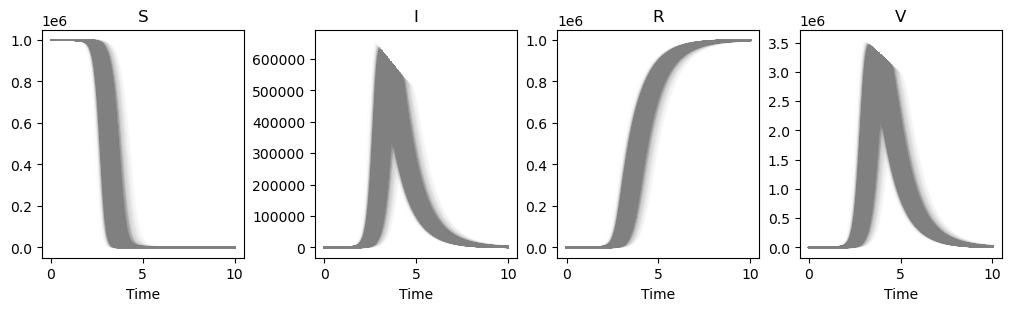

In [6]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, len(var_names), figsize=(10.0, 3.0), layout='compressed')
for i, name in enumerate(var_names):
    for j in range(int(results[name].shape[0]/2)):
        axs[i].plot(results_times, results[name][j, :], alpha=0.01, color='gray')
    axs[i].set_title(name)
    axs[i].set_xlabel('Time')

Package metadata

In [7]:
sample_size = int(idx_current/2)
results_exp = {n: [results[n][:sample_size, i] for i in range(len(results_times))] for n in var_names}
ecf_evals, _, ecf_eval_info = sim_lib.find_ecfs({n: results[n][:sample_size, :] for n in var_names})
metadata = sim_lib.Metadata(sample_size=sample_size,
                            simulator='deterministic',
                            ks_stat_mean=np.mean(ks_stats_samp),
                            ks_stat_stdev=np.std(ks_stats_samp),
                            sample_times=results_times,
                            ecf_evals=ecf_evals,
                            ecf_eval_info=ecf_eval_info,
                            param_dists=[sim_lib.ParamDist(param_name=n, dist_name=t[0], dist_params=t[1]) for n, t in param_dist.items()])
print(metadata)

if not os.path.isdir(res_dir):
    os.makedirs(res_dir)

fp = os.path.join(res_dir, 'sim_modeler.json')
with open(fp, 'w') as f:
    json.dump(metadata.to_json(), f, indent=4)

Sample size: 4790
Simulator: deterministic
K-S statistic: 0.05450077969917837, 0.00646541729108952
No. sample times: 101
Variables: ['S', 'I', 'R', 'V']
Significant figures: 15
Parameters sampled: ['beta']


Record data for later reuse

In [8]:
with open(os.path.join(res_dir, 'simdata_modeler.json'), 'w') as f:
    json.dump(dict(sample_size=idx_current,
                   sampling_err_thresh=sampling_err_thresh,
                   results_times=results_times.tolist(),
                   results={n: results[n].tolist() for n in var_names},
                   ks_stats_samp=ks_stats_samp,
                   err_hist=err_hist), 
              f, indent=4)

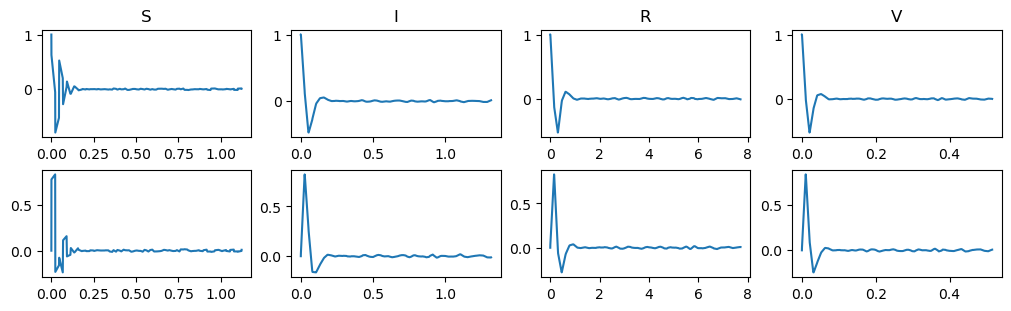

In [9]:
# Show a sample, to verify
idx_sample = 11
eval_t_sample = {n: sim_lib.get_eval_info_times(*ecf_eval_info[n][idx_sample]) for n in var_names}
ecfs_sample = {n: sim_lib.ecf(results_exp[n][idx_sample], eval_t_sample[n]) for n in var_names}

fig, axs = plt.subplots(2, len(var_names), figsize=(10.0, 3.0), layout='compressed')
for j, n in enumerate(var_names):
    for i in range(2):
        axs[i, j].plot(eval_t_sample[n], ecfs_sample[n][:, i])
    
    axs[0, j].set_title(n)

Show distribution of the final K-S statistic

(0.12667760442185858, 0.003664116886960825, 0.050430405353409105)
(0.054500783692373954, 4.180643039759933e-05)
0.05450077969917837 0.00646541729108952


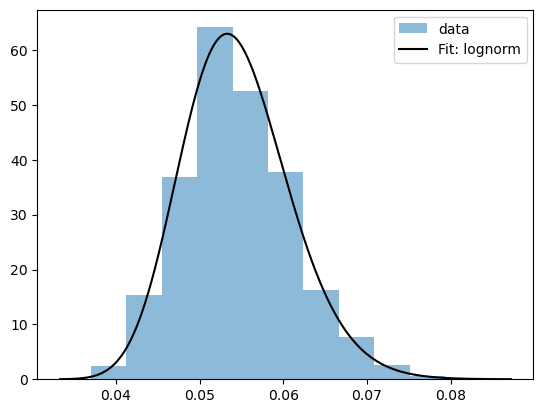

In [10]:
from scipy import stats

# All of these distributions generate a reasonable fit

# dist = stats.alpha
# dist = stats.betaprime
# dist = stats.exponnorm
# dist = stats.f
# dist = stats.fisk
# dist = stats.gamma
# dist = stats.genextreme
# dist = stats.genlogistic
# dist = stats.gennorm
# dist = stats.gumbel_r
# dist = stats.invgamma
# dist = stats.invgauss
# dist = stats.johnsonsb
# dist = stats.johnsonsu
# dist = stats.kstwobign
dist = stats.lognorm
# dist = stats.moyal
# dist = stats.norm
# dist = stats.norminvgauss
# dist = stats.pearson3
# dist = stats.recipinvgauss
# dist = stats.skewnorm
# dist = stats.weibull_max

plt.hist(ks_stats_samp, alpha=0.5, label='data', density=True)

fit = dist.fit(ks_stats_samp)
print(fit)
print(dist.stats(*fit))
print(np.average(ks_stats_samp), np.std(ks_stats_samp))

p = dist(*fit)
xmin = min(ks_stats_samp) * 0.9
xmax = max(ks_stats_samp) * 1.1
x = np.arange(xmin, xmax, (xmax - xmin)/1000)
plt.plot(x, p.pdf(x), 'k-', label='Fit: ' + dist.name)
_ = plt.legend()